## Algoritmo di Louvain

dopo il rilevamento iniziale della comunità, lo script controlla se ci sono meno di k cluster. Se ci sono, divide il cluster più grande in due cluster nel tentativo di raggiungere il numero desiderato di cluster (k). La divisione è fatta dividendo il cluster più grande in due metà approssimativamente uguali (nota che è una divisione arbitraria e non una ulteriore applicazione del metodo Louvain o un altro algoritmo di clustering).

## Verifica ammissibilità delle soluzioni ottenute

Per verificare l'ammissibilità della soluzione ottenuta possiamo creare una funzione che esegua i seguenti controlli:

Ogni nodo deve essere in un solo cluster: Possiamo controllare che la somma delle lunghezze dei cluster sia uguale al numero totale di nodi nel grafo.

Ogni nodo deve essere collegato in qualche modo ad un altro nodo del cluster: Possiamo controllare che per ogni nodo in un cluster, almeno uno dei suoi vicini è anche nel cluster.

0 -> 8, 4, 6, 1
1 -> 0, 8
2 -> 6, 9, 3
3 -> 6, 2
4 -> 0, 6
6 -> 0, 3, 4, 2
7 -> 9
8 -> 0, 1, 9
9 -> 2, 8, 7
Grafo iniziale:
La soluzione è ammissibile.


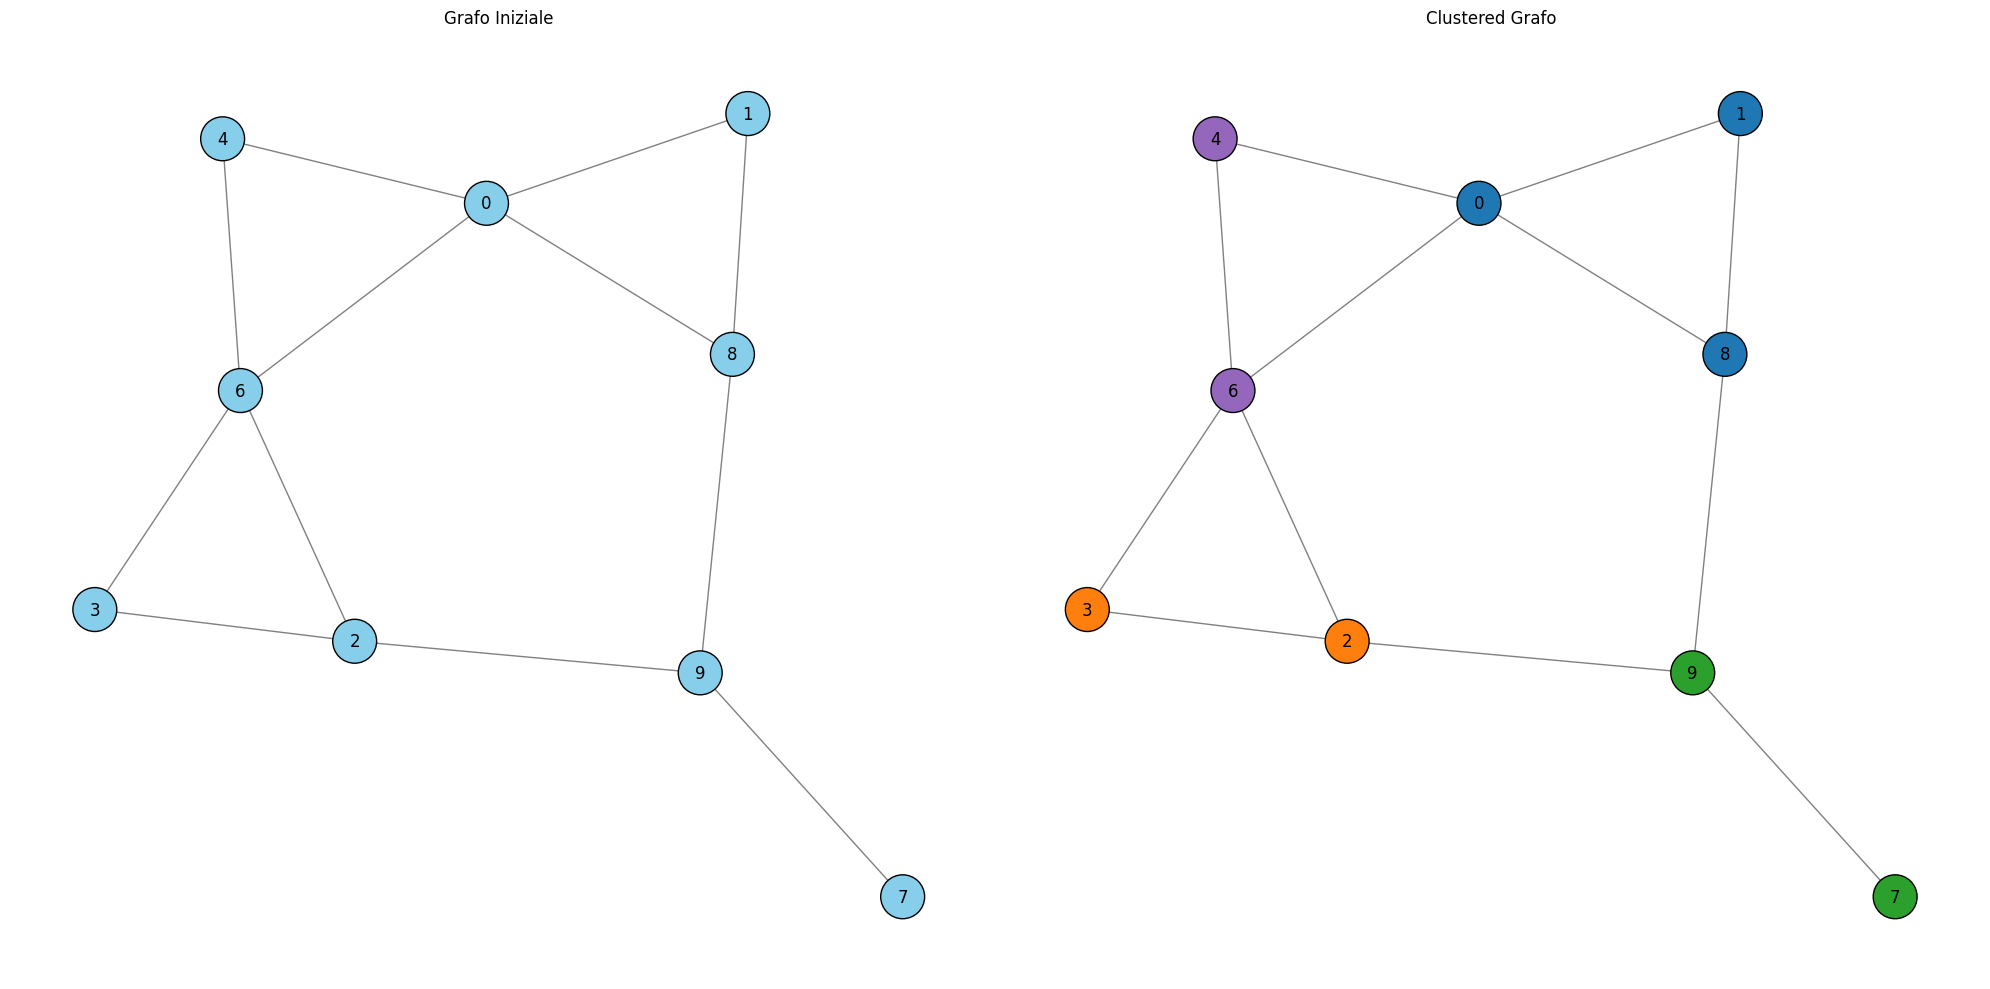

Tempo di esecuzione dell'algoritmo di Louvain: 0.00036454200744628906 secondi.


In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain 
import itertools
import time

def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

""" def divide_into_clusters(graph, k):
    partition = community_louvain.best_partition(graph)
    clusters = [[] for _ in range(k)]
    for node, cluster_index in partition.items():
        clusters[cluster_index].append(node)
    return clusters  """
    
def divide_into_clusters(graph, k):
    partition = community_louvain.best_partition(graph)
    clusters = [[] for _ in range(k)]
    for node, cluster_index in partition.items():
        clusters[cluster_index].append(node)

    while len([c for c in clusters if c]) < k:
        # Trova il cluster più grande
        max_cluster_index = max(range(k), key=lambda i: len(clusters[i]))
        if len(clusters[max_cluster_index]) < 2:
            # Se il cluster più grande ha meno di due nodi, non può essere diviso
            break
        # Sostituisci il cluster più grande con due nuovi cluster, divisi in modo casuale
        cluster = clusters[max_cluster_index]
        half = len(cluster) // 2
        clusters.append(cluster[:half])
        clusters[max_cluster_index] = cluster[half:]

    return clusters

def check_solution(graph, clusters):
    total_nodes = sum(len(cluster) for cluster in clusters)
    if total_nodes != graph.number_of_nodes():
        print("Ogni nodo deve essere in un solo cluster.")
        return False

    for cluster in clusters:
        for node in cluster:
            node_neighbors = set(graph.neighbors(node))
            cluster_set = set(cluster)
            if not node_neighbors & cluster_set:
                print("Ogni nodo deve essere collegato in qualche modo ad un altro nodo del cluster.")
                return False

    print("La soluzione è ammissibile.")
    return True


if __name__ == "__main__":
    grafo = Graph()
    for i in range(10):
        grafo.aggiungi_vertice(i)

    grafo.aggiungi_arco(0, 8)
    grafo.aggiungi_arco(0, 4)
    grafo.aggiungi_arco(0, 6)
    grafo.aggiungi_arco(1, 0)
    grafo.aggiungi_arco(1, 8)
    grafo.aggiungi_arco(6, 3)
    grafo.aggiungi_arco(6, 4)
    grafo.aggiungi_arco(6, 2)
    grafo.aggiungi_arco(2, 9)
    grafo.aggiungi_arco(3, 2)
    grafo.aggiungi_arco(8, 9)
    grafo.aggiungi_arco(9, 7)
    
    grafo.rimuovi_vertice(5)
    
    grafo.stampa_grafo()
    
    plt.figure(figsize=(20, 10))

    G_initial = converti_grafo_personalizzato_in_networkx(grafo)
    print("Grafo iniziale:")
    plot_graph(G_initial, "Grafo Iniziale", 121)

    k = 4
    start_time = time.time()
    clusters = divide_into_clusters(G_initial, k)
    # clusters, edge_count = divide_into_clusters(G_initial, k)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    clusters = divide_into_clusters(G_initial, k)
    check_solution(G_initial, clusters)

    plot_graph(G_initial, "Clustered Grafo", 122, colors=clusters)

    plt.tight_layout()
    plt.savefig("grafo.png")
    plt.show()

    print(f"Tempo di esecuzione dell'algoritmo di Louvain: {elapsed_time} secondi.")

### Senza  l'algoritmo di clustering di Louvain.

#### Utilizzo di un algoritmo gerarchico

Questo algoritmo inizia assegnando ciascun nodo al suo cluster e poi, ad ogni passo, fonde i due cluster più vicini fino a quando non rimangono solo k cluster. La "vicinanza" tra due cluster può essere definita in vari modi; in questo esempio, useremo la distanza minima tra i nodi di due cluster differenti.

0 -> 8, 4, 6, 1
1 -> 0, 8
2 -> 6, 9, 3
3 -> 6, 2
4 -> 0, 6
6 -> 0, 3, 4, 2
7 -> 9
8 -> 0, 1, 9
9 -> 2, 8, 7
Grafo iniziale:


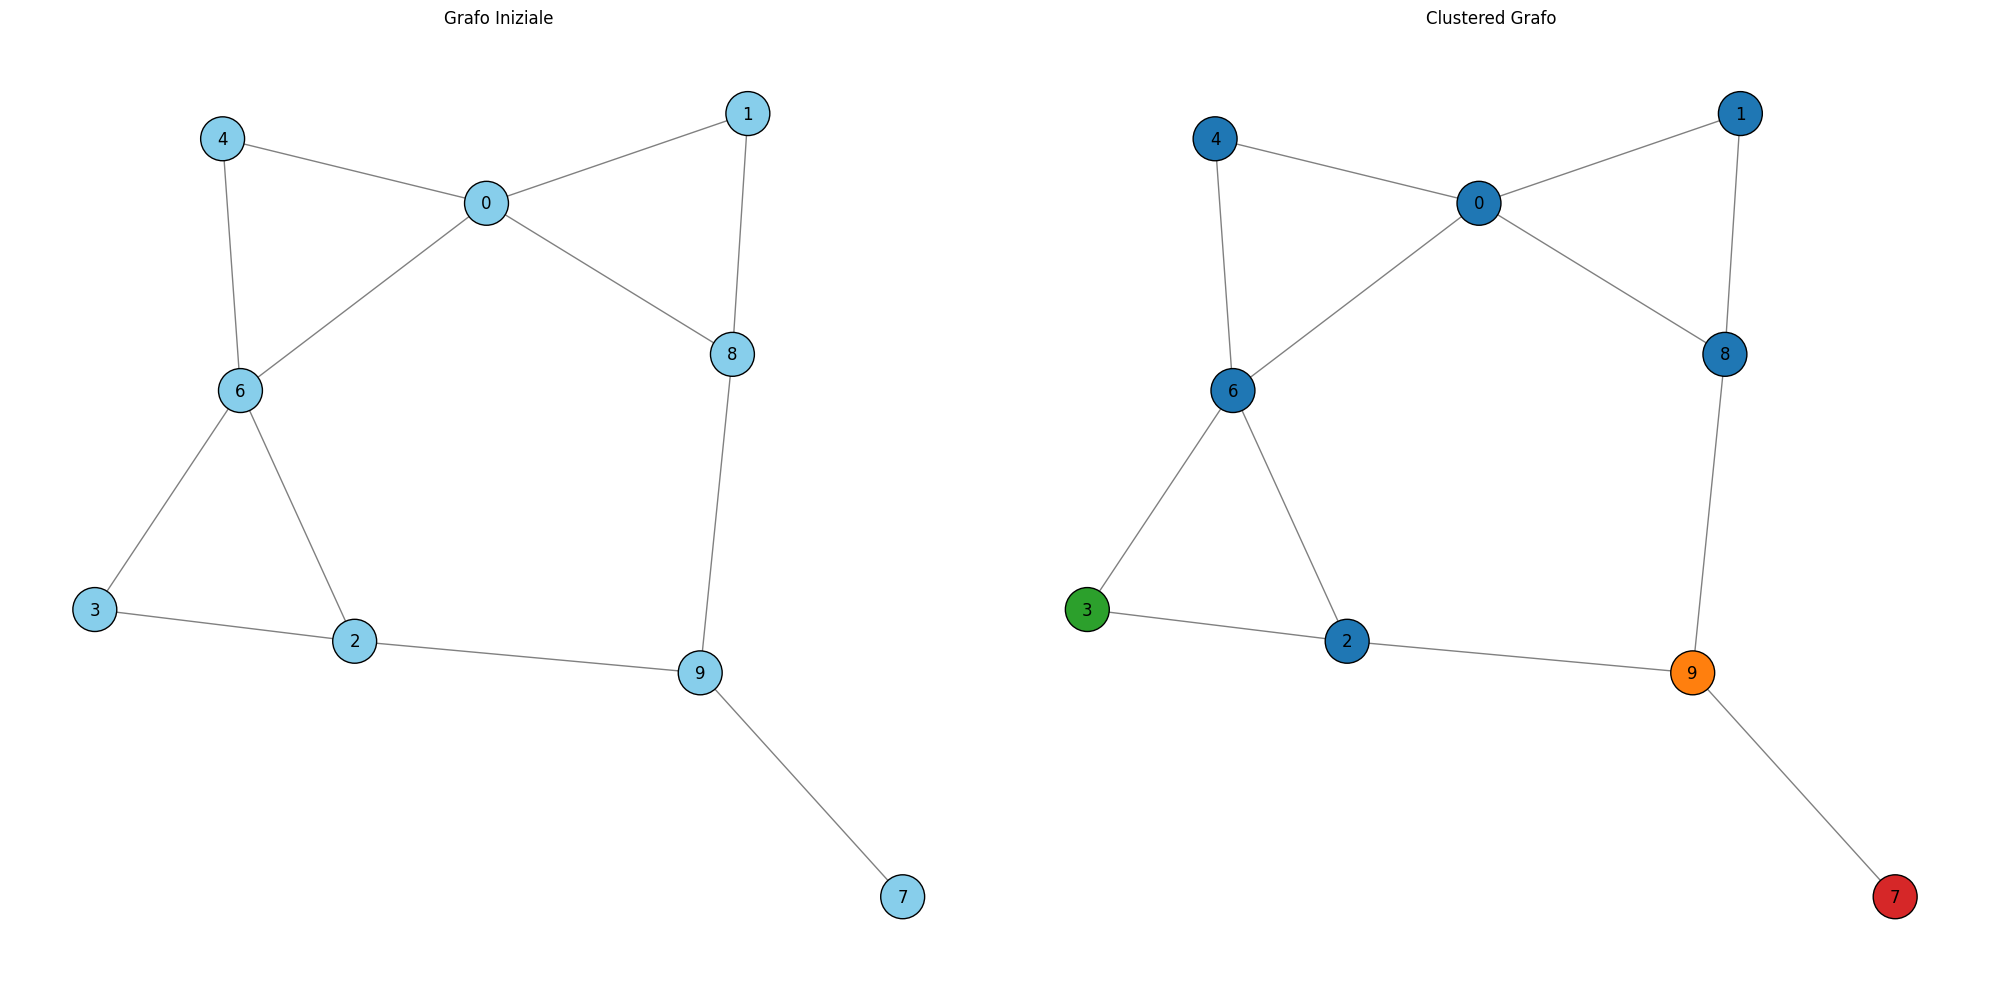

Tempo di esecuzione dell'algoritmo di clustering gerarchico: 0.0005788803100585938 secondi.


In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import time

def plot_graph(graph, title, subplot, colors=None):
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}

    node_colors = {node: 'skyblue' for node in graph.nodes()}
    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    plt.subplot(subplot)
    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)
    plt.title(title)

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u) 

    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

""" def distance(u, v):
    if v in G_initial[u]:
        return 1 / len(G_initial[u])
    else:
        return float('inf') """
def distance(u, v):
    try:
        return nx.shortest_path_length(G_initial, u, v)
    except nx.NetworkXNoPath:
        return float('inf')


def cluster_distance(cluster1, cluster2):
    return min(distance(u, v) for u in cluster1 for v in cluster2)

def find_closest_clusters(clusters):
    min_distance = float('inf')
    closest_clusters = None
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            dist = cluster_distance(clusters[i], clusters[j])
            if dist < min_distance:
                min_distance = dist
                closest_clusters = (i, j)
    return closest_clusters

def hierarchical_clustering(graph, k):
    clusters = [[node] for node in graph.nodes()]

    while len(clusters) > k:
        i, j = find_closest_clusters(clusters)
        clusters[i] += clusters[j]
        del clusters[j]

    return clusters

if __name__ == "__main__":
    grafo = Graph()

    grafo.aggiungi_vertice(0)
    grafo.aggiungi_vertice(1)
    grafo.aggiungi_vertice(2)
    grafo.aggiungi_vertice(3)
    grafo.aggiungi_vertice(4)
    grafo.aggiungi_vertice(6)
    grafo.aggiungi_vertice(7)
    grafo.aggiungi_vertice(8)
    grafo.aggiungi_vertice(9)

    grafo.aggiungi_arco(0, 8)
    grafo.aggiungi_arco(0, 4)
    grafo.aggiungi_arco(0, 6)
    grafo.aggiungi_arco(1, 0)
    grafo.aggiungi_arco(1, 8)
    grafo.aggiungi_arco(6, 3)
    grafo.aggiungi_arco(6, 4)
    grafo.aggiungi_arco(6, 2)
    grafo.aggiungi_arco(2, 9)
    grafo.aggiungi_arco(3, 2)
    grafo.aggiungi_arco(8, 9)
    grafo.aggiungi_arco(9, 7)

    grafo.stampa_grafo()

    G_initial = converti_grafo_personalizzato_in_networkx(grafo)

    plt.figure(figsize=(20, 10))  # Dimensioni della figura
    
    print("Grafo iniziale:")
    plot_graph(G_initial, "Grafo Iniziale", 121)  # Primo subplot 

    k = 4
    start_time = time.time()
    clusters = hierarchical_clustering(G_initial, k)
    end_time = time.time()
    elapsed_time = end_time - start_time

    plot_graph(G_initial, "Clustered Grafo", 122, colors=clusters)  # Secondo subplot 

    plt.tight_layout()
    plt.savefig("grafo.png")
    plt.show()

    print(f"Tempo di esecuzione dell'algoritmo di clustering gerarchico: {elapsed_time} secondi.")

# Greedy

Questo approccio prevede che i cluster più grandi vengano continuamente divisi finché non abbiamo il numero desiderato di cluster. È un approccio "greedy" perché ad ogni passaggio scegliamo semplicemente il cluster più grande e lo dividiamo, senza preoccuparci se questa scelta potrebbe essere ottimale nel lungo termine.

0 -> 8, 4, 6, 1
1 -> 0, 8
2 -> 6, 9, 3
3 -> 6, 2
4 -> 0, 6
6 -> 0, 3, 4, 2
7 -> 9
8 -> 0, 1, 9
9 -> 2, 8, 7
Grafo iniziale:


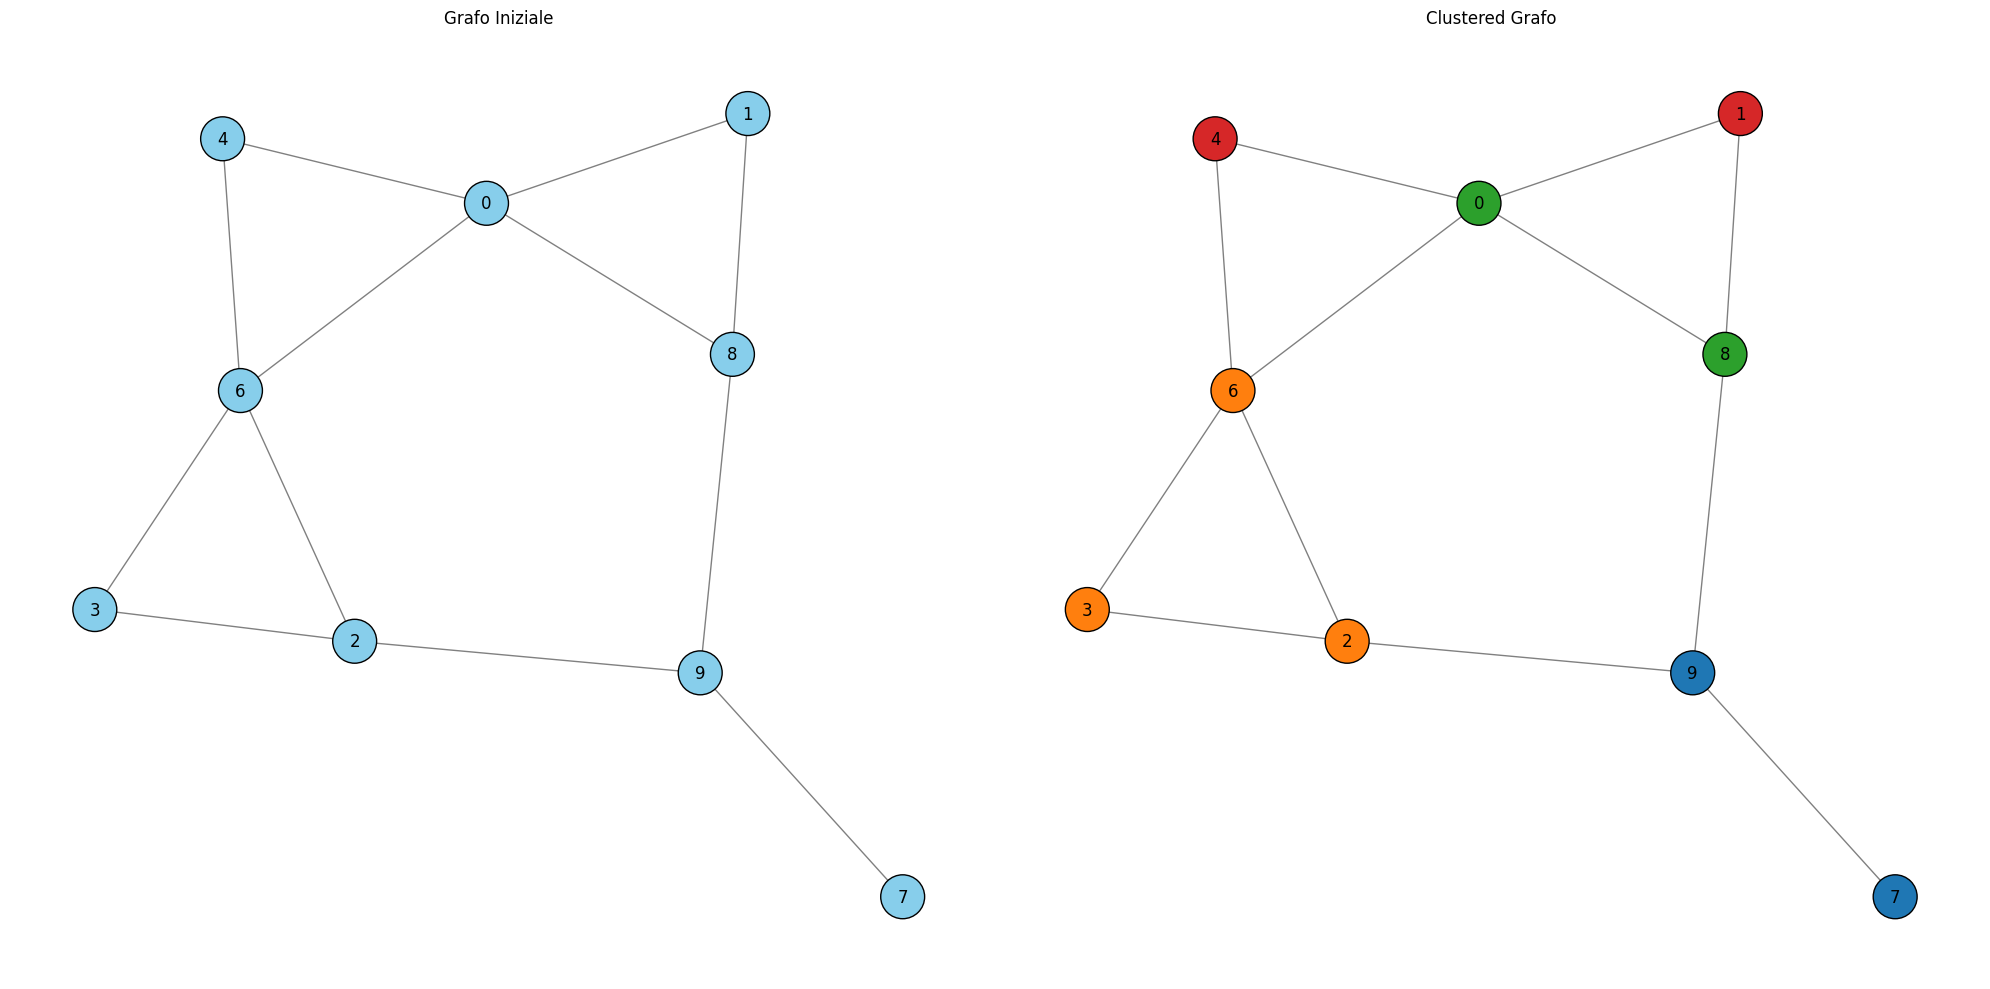

Tempo di esecuzione dell'algoritmo Greedy: 0.00037288665771484375 secondi.


In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain 
import itertools
import time

def plot_graph(graph, title, subplot_position=None, filename=None, colors=None):
    plt.subplot(subplot_position) if subplot_position else plt.figure()
    pos = nx.spring_layout(graph, seed=42)
    labels = {node: str(node) for node in graph.nodes()}
    node_colors = {node: 'skyblue' for node in graph.nodes()}

    if colors:
        color_cycle = itertools.cycle(plt.cm.tab10.colors)
        for i, cluster in enumerate(colors):
            color = next(color_cycle)
            for node in cluster:
                node_colors[int(node)] = color

    nx.set_node_attributes(graph, node_colors, 'color')

    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=1000, node_color=list(node_colors.values()), 
            font_size=12, font_color='black', edge_color='gray', edgecolors='black', linewidths=1)

    plt.title(title)
    if filename and not subplot_position:
        plt.savefig(filename)
    if not subplot_position:
        plt.show()

class Graph:
    def __init__(self):
        self.grafo = {}

    def aggiungi_vertice(self, vertice):
        if vertice not in self.grafo:
            self.grafo[vertice] = []

    def aggiungi_arco(self, u, v):
        if u in self.grafo and v in self.grafo:
            self.grafo[u].append(v)
            self.grafo[v].append(u)

    def rimuovi_vertice(self, vertice):
        if vertice in self.grafo:
            self.grafo.pop(vertice, None)
            for nodo, adiacenti in self.grafo.items():
                if vertice in adiacenti:
                    adiacenti.remove(vertice)


    def stampa_grafo(self):
        for vertice in self.grafo:
            adiacenti = ", ".join(str(v) for v in self.grafo[vertice])
            print(f"{vertice} -> {adiacenti}")

def converti_grafo_personalizzato_in_networkx(grafo_personalizzato):
    G = nx.Graph()
    for vertice, adiacenti in grafo_personalizzato.grafo.items():
        G.add_node(vertice)
        for adiacente in adiacenti:
            G.add_edge(vertice, adiacente)
    return G

    
def divide_into_clusters(graph, k):
    partition = community_louvain.best_partition(graph)
    clusters = [[] for _ in range(max(partition.values())+1)]
    for node, cluster_index in partition.items():
        clusters[cluster_index].append(node)

    while len(clusters) < k:
        # Trova il cluster più grande
        max_cluster_index = max(range(len(clusters)), key=lambda i: len(clusters[i]))
        if len(clusters[max_cluster_index]) < 2:
            # Se il cluster più grande ha meno di due nodi, non può essere diviso
            break

        # Divide il cluster più grande in due
        cluster_to_divide = clusters.pop(max_cluster_index)
        cluster_1, cluster_2 = cluster_to_divide[:len(cluster_to_divide)//2], cluster_to_divide[len(cluster_to_divide)//2:]
        clusters.append(cluster_1)
        clusters.append(cluster_2)

    return clusters



if __name__ == "__main__":
    grafo = Graph()
    for i in range(10):
        grafo.aggiungi_vertice(i)

    grafo.aggiungi_arco(0, 8)
    grafo.aggiungi_arco(0, 4)
    grafo.aggiungi_arco(0, 6)
    grafo.aggiungi_arco(1, 0)
    grafo.aggiungi_arco(1, 8)
    grafo.aggiungi_arco(6, 3)
    grafo.aggiungi_arco(6, 4)
    grafo.aggiungi_arco(6, 2)
    grafo.aggiungi_arco(2, 9)
    grafo.aggiungi_arco(3, 2)
    grafo.aggiungi_arco(8, 9)
    grafo.aggiungi_arco(9, 7)
    
    grafo.rimuovi_vertice(5)
    
    grafo.stampa_grafo()
    
    plt.figure(figsize=(20, 10))

    G_initial = converti_grafo_personalizzato_in_networkx(grafo)
    print("Grafo iniziale:")
    plot_graph(G_initial, "Grafo Iniziale", 121)

    k = 4
    start_time = time.time()
    clusters = divide_into_clusters(G_initial, k)
    # clusters, edge_count = divide_into_clusters(G_initial, k)
    end_time = time.time()
    elapsed_time = end_time - start_time

    plot_graph(G_initial, "Clustered Grafo", 122, colors=clusters)

    plt.tight_layout()
    plt.savefig("grafo.png")
    plt.show()

    print(f"Tempo di esecuzione dell'algoritmo Greedy: {elapsed_time} secondi.")